In [ ]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import cv2
import numpy as np
import re
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab import drive, output

# Mount Google Drive
drive.mount('/content/drive')

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


: 

In [ ]:
# Extract the tar file if needed
!tar -xzvf /content/drive/MyDrive/huruf_data/train.tar.gz -C /content/
TRAINING_DATA = "/content/train"


Streaming output truncated to the last 5000 lines.
train/id_10143_label_8.png
train/id_10152_label_9.png
train/id_10178_label_13.png
train/id_10217_label_18.png
train/id_1024_label_16.png
train/id_10291_label_27.png
train/id_10315_label_2.png
train/id_10387_label_11.png
train/id_10413_label_14.png
train/id_10422_label_15.png
train/id_10452_label_19.png
train/id_1026_label_17.png
train/id_1067_label_22.png
train/id_10457_label_20.png
train/id_10480_label_22.png
train/id_104_label_13.png
train/id_10525_label_28.png
train/id_10529_label_1.png
train/id_10536_label_1.png
train/id_1053_label_20.png
train/id_1054_label_20.png
train/id_10553_label_4.png
train/id_10558_label_4.png
train/id_10620_label_12.png
train/id_10622_label_12.png
train/id_10631_label_13.png
train/id_10646_label_15.png
train/id_10648_label_15.png
train/id_10666_label_18.png
train/id_10675_label_19.png
train/id_10679_label_19.png
train/id_10683_label_20.png
train/id_10701_label_22.png
train/id_10745_label_28.png
train/id_10

In [20]:
def load_data(data_path, img_size=32):
    data_path = Path(data_path)
    samples, labels = [], []
    label_pattern = re.compile(r"id_\d+_label_(\d+)\.png")

    for file_path in data_path.glob("*.png"):
        if not file_path.exists():
            continue
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY) if img.shape[2]==4 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_size, img_size)).astype(np.float32)/255.0
        samples.append(img)
        match = label_pattern.search(file_path.name)
        if match:
            labels.append(int(match.group(1))-1)

    X = np.expand_dims(np.array(samples), axis=1)
    y = np.array(labels, dtype=np.int64)
    return X, y

# Load data
X, y = load_data(TRAINING_DATA)
print(f"Data loaded: X={X.shape}, y={y.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to tensors once
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)


Data loaded: X=(13439, 1, 32, 32), y=(13439,)


In [21]:
class ArabicDatasetGPU(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # (1,H,W)
        label = self.labels[idx]

        # GPU-friendly lightweight augmentation
        if self.augment:
            if torch.rand(1) < 0.5:
                img = torch.flip(img, [-1])  # horizontal flip

        return img, label

# Large batch + parallel loading
batch_size = 128

train_dataset = ArabicDatasetGPU(X_train_tensor, y_train_tensor, augment=True)
test_dataset  = ArabicDatasetGPU(X_test_tensor, y_test_tensor, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
class OptimizedArabicCNN(nn.Module):
    def __init__(self, num_classes=28):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.15),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )

    def forward(self,x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = OptimizedArabicCNN(num_classes=28).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


In [23]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {val_acc:.4f}")


Epoch 1/100 | Loss: 2.6032 | Test Acc: 0.5513
Epoch 2/100 | Loss: 1.3933 | Test Acc: 0.6894
Epoch 3/100 | Loss: 0.9880 | Test Acc: 0.6648
Epoch 4/100 | Loss: 0.8162 | Test Acc: 0.7344
Epoch 5/100 | Loss: 0.6976 | Test Acc: 0.7812
Epoch 6/100 | Loss: 0.6477 | Test Acc: 0.8624
Epoch 7/100 | Loss: 0.5920 | Test Acc: 0.8597
Epoch 8/100 | Loss: 0.5610 | Test Acc: 0.8932
Epoch 9/100 | Loss: 0.5115 | Test Acc: 0.8836
Epoch 10/100 | Loss: 0.4783 | Test Acc: 0.8940
Epoch 11/100 | Loss: 0.4733 | Test Acc: 0.8296
Epoch 12/100 | Loss: 0.4381 | Test Acc: 0.9156
Epoch 13/100 | Loss: 0.4242 | Test Acc: 0.8821
Epoch 14/100 | Loss: 0.4021 | Test Acc: 0.9036
Epoch 15/100 | Loss: 0.3863 | Test Acc: 0.9178
Epoch 16/100 | Loss: 0.3708 | Test Acc: 0.9219
Epoch 17/100 | Loss: 0.3692 | Test Acc: 0.9111
Epoch 18/100 | Loss: 0.3501 | Test Acc: 0.9122
Epoch 19/100 | Loss: 0.3241 | Test Acc: 0.9107
Epoch 20/100 | Loss: 0.3240 | Test Acc: 0.9100
Epoch 21/100 | Loss: 0.2781 | Test Acc: 0.9338
Epoch 22/100 | Loss: 0

In [24]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print(f"Final Test Accuracy: {correct/total:.2%}")


Final Test Accuracy: 95.50%


✅ Predicted Arabic Letter:
→ ح


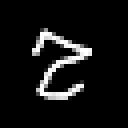

In [25]:
from google.colab import output
from IPython.display import HTML, display, clear_output
import base64
from PIL import Image
import io
import torch
import numpy as np

# Arabic alphabet list (for mapping indices)
arabic_alphabet = [
    "ا", "ب", "ت", "ث", "ج", "ح", "خ", "د", "ذ", "ر", "ز", "س", "ش", "ص",
    "ض", "ط", "ظ", "ع", "غ", "ف", "ق", "ك", "ل", "م", "ن", "ه", "و", "ي"
]

canvas_html = """
<div style="background: #1a1a1a; padding: 20px; border-radius: 8px; display: inline-block; color: white; font-family: sans-serif;">
    <p style="margin-top:0">Drawing Mode: <b>White on Black</b></p>
    <canvas id="canvas" width="32" height="32"
            style="border:1px solid #444; width:320px; height:320px;
            image-rendering: pixelated; background-color: black; cursor: crosshair;">
    </canvas>
    <div style="margin-top: 15px; display: flex; gap: 10px;">
        <button id="save" style="padding: 8px 16px; background: #2ecc71; color: white; border: none; cursor: pointer; border-radius: 4px;">Predict</button>
        <button id="clear" style="padding: 8px 16px; background: #e74c3c; color: white; border: none; cursor: pointer; border-radius: 4px;">Clear Board</button>
    </div>
</div>

<script>
    var canvas = document.getElementById('canvas');
    var ctx = canvas.getContext('2d', {alpha: false});

    function initCanvas() {
        ctx.fillStyle = "black";
        ctx.fillRect(0, 0, 32, 32);
        ctx.lineWidth = 1.2;
        ctx.lineCap = 'round';
        ctx.strokeStyle = "white";
    }

    initCanvas();
    var drawing = false;
    canvas.onmousedown = () => { drawing = true; };
    canvas.onmouseup = () => { drawing = false; ctx.beginPath(); };
    canvas.onmousemove = (e) => {
        if (!drawing) return;
        var rect = canvas.getBoundingClientRect();
        var x = (e.clientX - rect.left) / (rect.width / 32);
        var y = (e.clientY - rect.top) / (rect.height / 32);
        ctx.lineTo(x, y);
        ctx.stroke();
        ctx.beginPath();
        ctx.moveTo(x, y);
    };

    document.getElementById('save').onclick = () => {
        var data = canvas.toDataURL('image/png');
        google.colab.kernel.invokeFunction('notebook.SaveAndPredict', [data], {});
    };

    document.getElementById('clear').onclick = initCanvas;
</script>
"""

# Callback function to process the image and predict
def SaveAndPredict(data_url):
    header, encoded = data_url.split(",", 1)
    data = base64.b64decode(encoded)

    # Open as grayscale and resize to (32,32)
    img = Image.open(io.BytesIO(data)).convert('L')
    img = img.resize((32,32), resample=Image.NEAREST)

    # Convert to tensor (1,1,32,32) and normalize
    img_tensor = torch.tensor(np.expand_dims(np.array(img, dtype=np.float32)/255.0, axis=(0,1)), device=DEVICE)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        predicted_index = torch.argmax(output, 1).item()

    clear_output(wait=True)
    display(HTML(canvas_html))

    print("✅ Predicted Arabic Letter:")
    print(f"→ {arabic_alphabet[predicted_index]}")

    # Show drawn image enlarged
    display(img.resize((128,128), resample=Image.NEAREST))

# Register callback and display canvas
output.register_callback('notebook.SaveAndPredict', SaveAndPredict)
display(HTML(canvas_html))
